## Project 4 - NLP with Twitter Sentiments

In [1]:
import pandas as pd
import numpy as np
import string
import re

from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer 
from nltk import FreqDist

from matplotlib import pyplot as plt
import seaborn as sns

## Text Preprocessing

Before modeling, the text needs to be cleaned and processed so that it is suitable for modeling. I'll take out undesired characters and rows from the data, tokenize, and then ultimately vectorize the text.

In [2]:
# Load data and take a first look
data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', 
                   encoding='ansi')
df = pd.DataFrame(data)
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [3]:
# rename columns to shorter names and look at info
df = df.rename(columns={'emotion_in_tweet_is_directed_at':'subject',
                        'is_there_an_emotion_directed_at_a_brand_or_product':'sentiment'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text    9092 non-null object
subject       3291 non-null object
sentiment     9093 non-null object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
# get a list of the sentiment categories
sentiments = list(set(df['sentiment']))
sentiments

["I can't tell",
 'Positive emotion',
 'Negative emotion',
 'No emotion toward brand or product']

In [5]:
# rename the categories to simpler labels
df['sentiment'] = df['sentiment'].replace(to_replace='Positive emotion', value ='positive')
df['sentiment'] = df['sentiment'].replace(to_replace='Negative emotion', value ='negative')
df['sentiment'] = df['sentiment'].replace(to_replace='''I can't tell''', value ='unknown')
df['sentiment'] = df['sentiment'].replace(to_replace='No emotion toward brand or product', value ='neutral')

In [6]:
# drop rows without tweet text and fill renaming nan values with 'none'
df = df.dropna(subset=['tweet_text'])
df = df.fillna('none')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text    9092 non-null object
subject       9092 non-null object
sentiment     9092 non-null object
dtypes: object(3)
memory usage: 284.1+ KB


In [7]:
# function to preprocess single-column dataframe and return a list of the cleaned text
def preprocess(df):
    acceptable = re.compile('[a-zA-Z @]') # regex expression to keep letters and handles

    # make a list of the text that fits with regex above
    cleanedtext = []
    for text in df:
        p = ''.join(acceptable.findall(text)).lower()
        cleanedtext.append(p)
    
    return cleanedtext

In [8]:
# make a n ew column of the clean text
df['cleaned_text'] = preprocess(df['tweet_text'])
df

,tweet_text,subject,sentiment,cleaned_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,@wesley i have a g iphone after hrs tweeting ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,@jessedee know about @fludapp awesome ipadiph...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,@swonderlin can not wait for ipad also they s...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,@sxsw i hope this years festival isnt as crash...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,@sxtxstate great stuff on fri sxsw marissa may...
...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,positive,ipad everywhere sxsw link
9089,"Wave, buzz... RT @mention We interrupt your re...",none,neutral,wave buzz rt @mention we interrupt your regula...
9090,"Google's Zeiger, a physician never reported po...",none,neutral,googles zeiger a physician never reported pote...
9091,Some Verizon iPhone customers complained their...,none,neutral,some verizon iphone customers complained their...


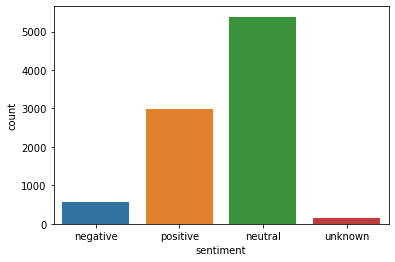

In [9]:
# Look at the counts for each category
ax = sns.countplot(x='sentiment', data=df)

In [10]:
# drop unknown sentiments
df = df[df['sentiment'] != 'unknown']

In [11]:
# tokenize the tweet text
tt = TweetTokenizer(strip_handles=True, reduce_len=True, preserve_case=False)
df['tokenized_text'] = df['cleaned_text'].apply(tt.tokenize)

C:\Users\cm_fr\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
# reset the index and review tokenized text
df = df.reset_index(drop=True)
df

,tweet_text,subject,sentiment,cleaned_text,tokenized_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,@wesley i have a g iphone after hrs tweeting ...,"[i, have, a, g, iphone, after, hrs, tweeting, ..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,@jessedee know about @fludapp awesome ipadiph...,"[know, about, awesome, ipadiphone, app, that, ..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,@swonderlin can not wait for ipad also they s...,"[can, not, wait, for, ipad, also, they, should..."
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,@sxsw i hope this years festival isnt as crash...,"[i, hope, this, years, festival, isnt, as, cra..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,@sxtxstate great stuff on fri sxsw marissa may...,"[great, stuff, on, fri, sxsw, marissa, mayer, ..."
...,...,...,...,...,...
8931,Ipad everywhere. #SXSW {link},iPad,positive,ipad everywhere sxsw link,"[ipad, everywhere, sxsw, link]"
8932,"Wave, buzz... RT @mention We interrupt your re...",none,neutral,wave buzz rt @mention we interrupt your regula...,"[wave, buzz, rt, we, interrupt, your, regularl..."
8933,"Google's Zeiger, a physician never reported po...",none,neutral,googles zeiger a physician never reported pote...,"[googles, zeiger, a, physician, never, reporte..."
8934,Some Verizon iPhone customers complained their...,none,neutral,some verizon iphone customers complained their...,"[some, verizon, iphone, customers, complained,..."


In [13]:
# input tokenized df and list of words to remove, return the cleaned list
def remove_words(df, to_remove):
    cleaned = []
    for text in df:
        cleaned.append([w for w in text if w not in to_remove])
    return cleaned

In [14]:
# remove English language stopwords and add revisions to new column
stopwords_list = stopwords.words('english')
df['stopped_tokens'] = remove_words(df['tokenized_text'], stopwords_list)

In [15]:
df.head()

,tweet_text,subject,sentiment,cleaned_text,tokenized_text,stopped_tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,@wesley i have a g iphone after hrs tweeting ...,"[i, have, a, g, iphone, after, hrs, tweeting, ...","[g, iphone, hrs, tweeting, riseaustin, dead, n..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,@jessedee know about @fludapp awesome ipadiph...,"[know, about, awesome, ipadiphone, app, that, ...","[know, awesome, ipadiphone, app, youll, likely..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,@swonderlin can not wait for ipad also they s...,"[can, not, wait, for, ipad, also, they, should...","[wait, ipad, also, sale, sxsw]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,@sxsw i hope this years festival isnt as crash...,"[i, hope, this, years, festival, isnt, as, cra...","[hope, years, festival, isnt, crashy, years, i..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,@sxtxstate great stuff on fri sxsw marissa may...,"[great, stuff, on, fri, sxsw, marissa, mayer, ...","[great, stuff, fri, sxsw, marissa, mayer, goog..."


In [16]:
# Lemmatize stopped tokens and create new column with lemmed words
lemmatizer = WordNetLemmatizer()
lemmed_tokens=[]
for text in df['stopped_tokens']:
    lemmed_tokens.append([lemmatizer.lemmatize(w) for w in text]) 
df['lemmed_tokens'] = lemmed_tokens

In [17]:
df.head()

,tweet_text,subject,sentiment,cleaned_text,tokenized_text,stopped_tokens,lemmed_tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,negative,@wesley i have a g iphone after hrs tweeting ...,"[i, have, a, g, iphone, after, hrs, tweeting, ...","[g, iphone, hrs, tweeting, riseaustin, dead, n...","[g, iphone, hr, tweeting, riseaustin, dead, ne..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,positive,@jessedee know about @fludapp awesome ipadiph...,"[know, about, awesome, ipadiphone, app, that, ...","[know, awesome, ipadiphone, app, youll, likely...","[know, awesome, ipadiphone, app, youll, likely..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,positive,@swonderlin can not wait for ipad also they s...,"[can, not, wait, for, ipad, also, they, should...","[wait, ipad, also, sale, sxsw]","[wait, ipad, also, sale, sxsw]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,negative,@sxsw i hope this years festival isnt as crash...,"[i, hope, this, years, festival, isnt, as, cra...","[hope, years, festival, isnt, crashy, years, i...","[hope, year, festival, isnt, crashy, year, iph..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,positive,@sxtxstate great stuff on fri sxsw marissa may...,"[great, stuff, on, fri, sxsw, marissa, mayer, ...","[great, stuff, fri, sxsw, marissa, mayer, goog...","[great, stuff, fri, sxsw, marissa, mayer, goog..."


In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

In [19]:
# function to remove single-instance words from a list of tweets
def remove_singles(col):
    all_words = []
    for text in col:
        all_words += [w for w in text]
    freqdist = FreqDist(all_words)
    removable_words = [x[0] for x in freqdist.most_common(3)]
    single_words = [x[0] for x in freqdist.most_common() if x[1]==1]
    removable_words += single_words 
    list_of_strings = remove_words(col, removable_words)
    list_of_sentences = [' '.join(q) for q in list_of_strings]
    return list_of_sentences

In [20]:
# Remove single words from current dataframe
X2 = remove_singles(df['lemmed_tokens'])

In [21]:
# function to take a dataframe and return a vectorized dataframe
def vectorize(df):
    vec = CountVectorizer()
    X = vec.fit_transform(df)
    df2 = pd.DataFrame(X.toarray(), columns = vec.get_feature_names())
    return df2

In [22]:
# input tokenized df and list of words to remove, return the cleaned list
def remove_words(df, to_remove):
    cleaned = []
    for text in df:
        cleaned.append([w for w in text if w not in to_remove])
    return cleaned

In [23]:
# Look at popular words for each sentiment
df_pos = df[df['sentiment']=='positive']['lemmed_tokens']
df_neg = df[df['sentiment']=='negative']['lemmed_tokens']
df_nn = df[df['sentiment']=='neutral']['lemmed_tokens']

In [24]:
# Remove the Twitter and sxsw words
to_remove = ['sxsw', 'link', 'rt', 'amp', 'apple', 'google', 'iphone', 'ipad', 'android', 'store', 'app', 'new', 'austin']
df_pos = remove_words(df_pos, to_remove)
df_neg = remove_words(df_neg, to_remove)
df_nn = remove_words(df_nn, to_remove)

In [25]:
# Functiom to look at top words for each dataset
def top_words(col, how_many):
    all_words = []
    for text in col:
        all_words += [w for w in text]
    freqdist = FreqDist(all_words)
    return freqdist.most_common(how_many)

In [26]:
# make list of top words for each sentiment
pos_tops = ' '.join([x[0] for x in top_words(df_pos, 25)])
neg_tops = ' '.join([x[0] for x in top_words(df_neg, 25)])
nn_tops = ' '.join([x[0] for x in top_words(df_nn, 25)])

In [27]:
pos_tops

'popup get launch one line party great time via social free day cool map win im like today circle go come mobile sxswi love network'

In [28]:
from wordcloud import WordCloud, STOPWORDS

In [35]:
# Generate word clounds to visualize top words
def world_cloud(tops):
    wordcloud = WordCloud(width = 3000, 
                          height = 2000, 
                          random_state=1, 
                          background_color='grey', 
                          collocations=False, 
                          stopwords = STOPWORDS
                         ).generate(tops)
    #Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    plt.show()

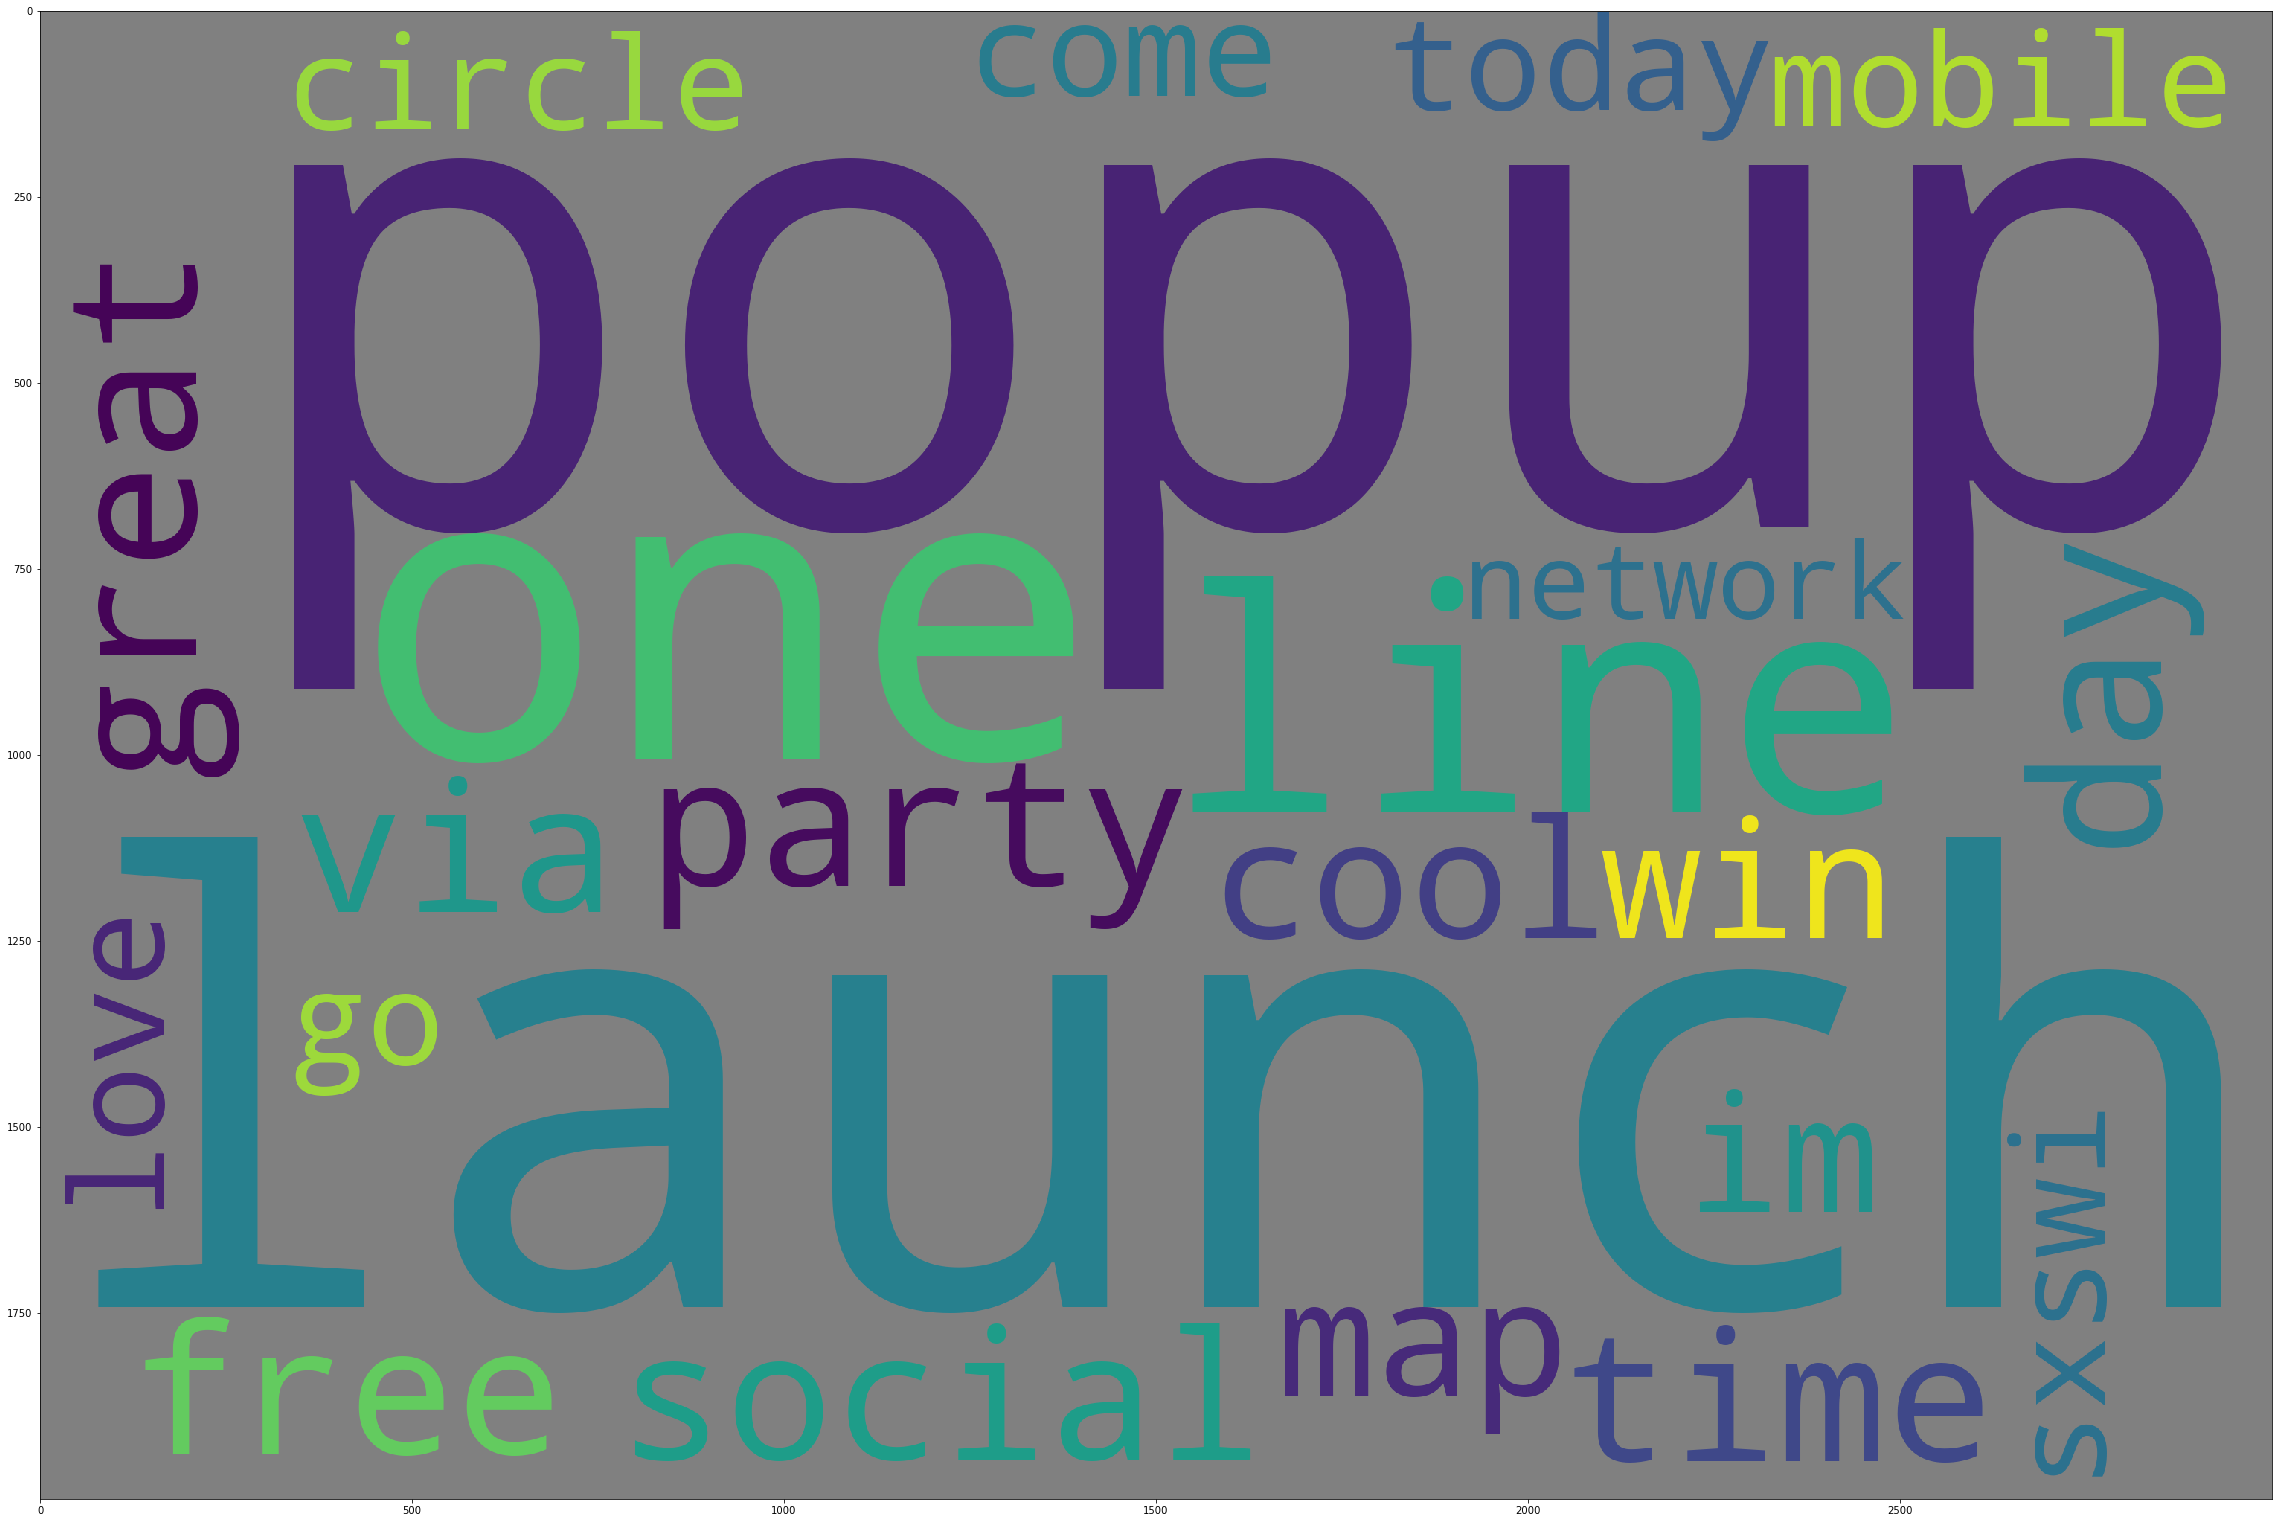

In [34]:
world_cloud(pos_tops)

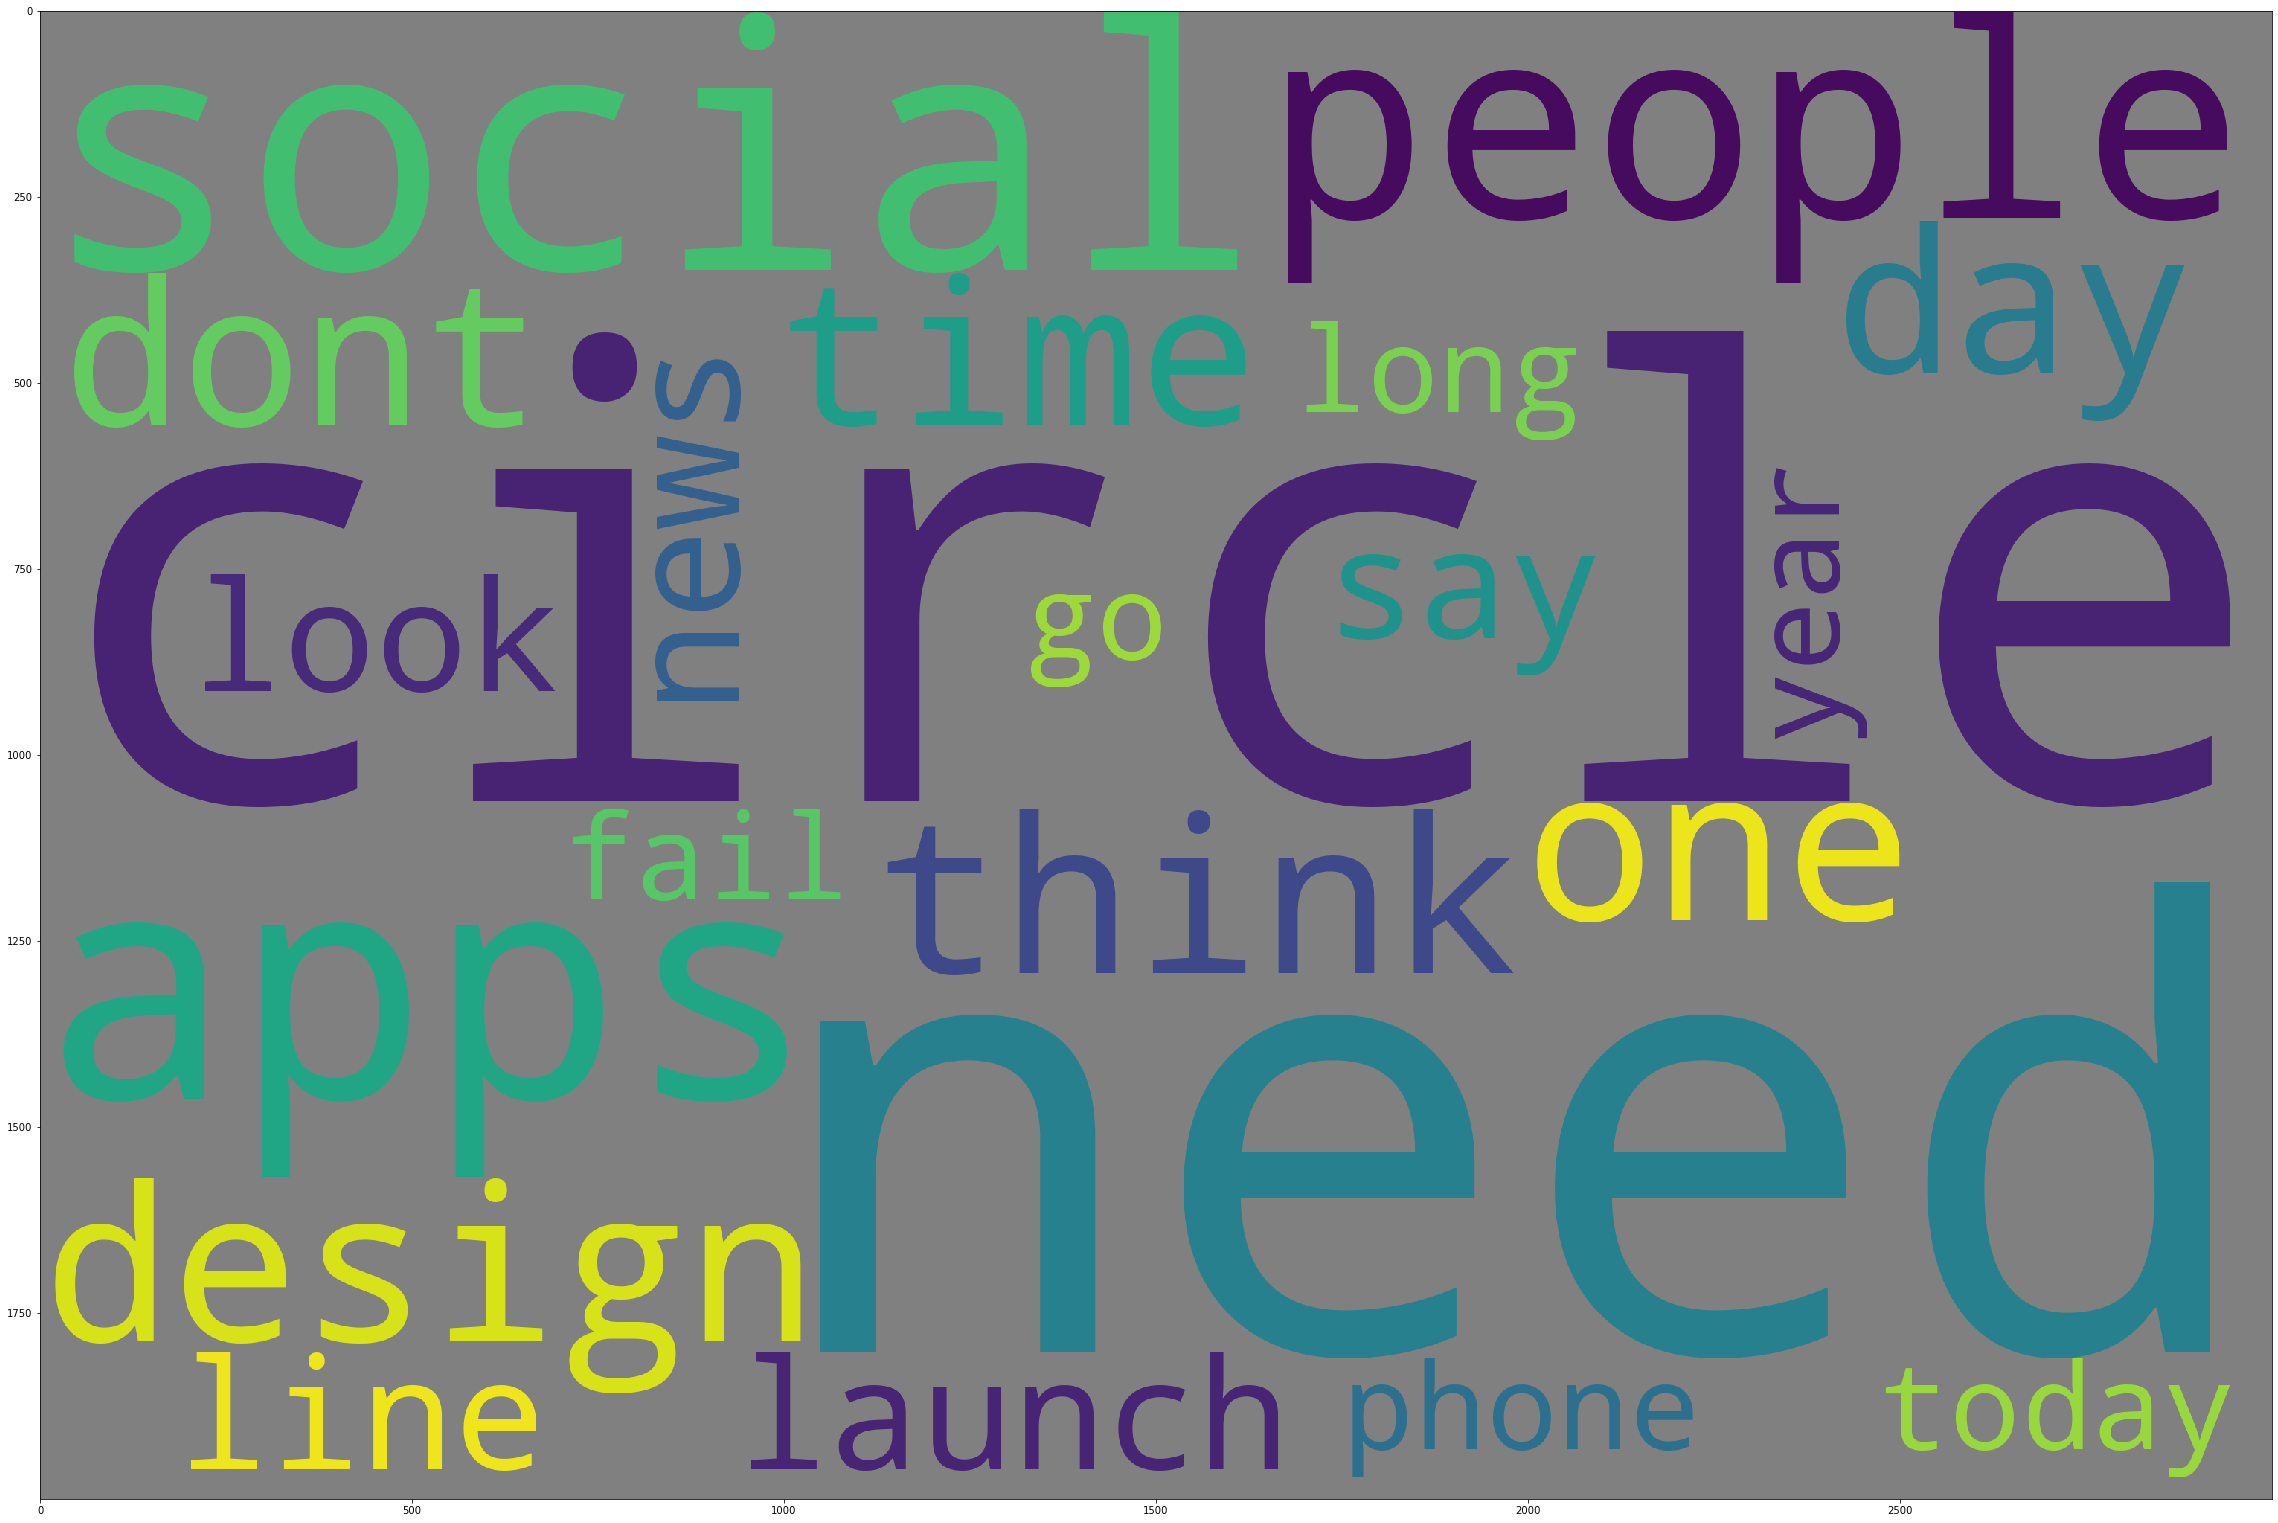

In [31]:
world_cloud(neg_tops)

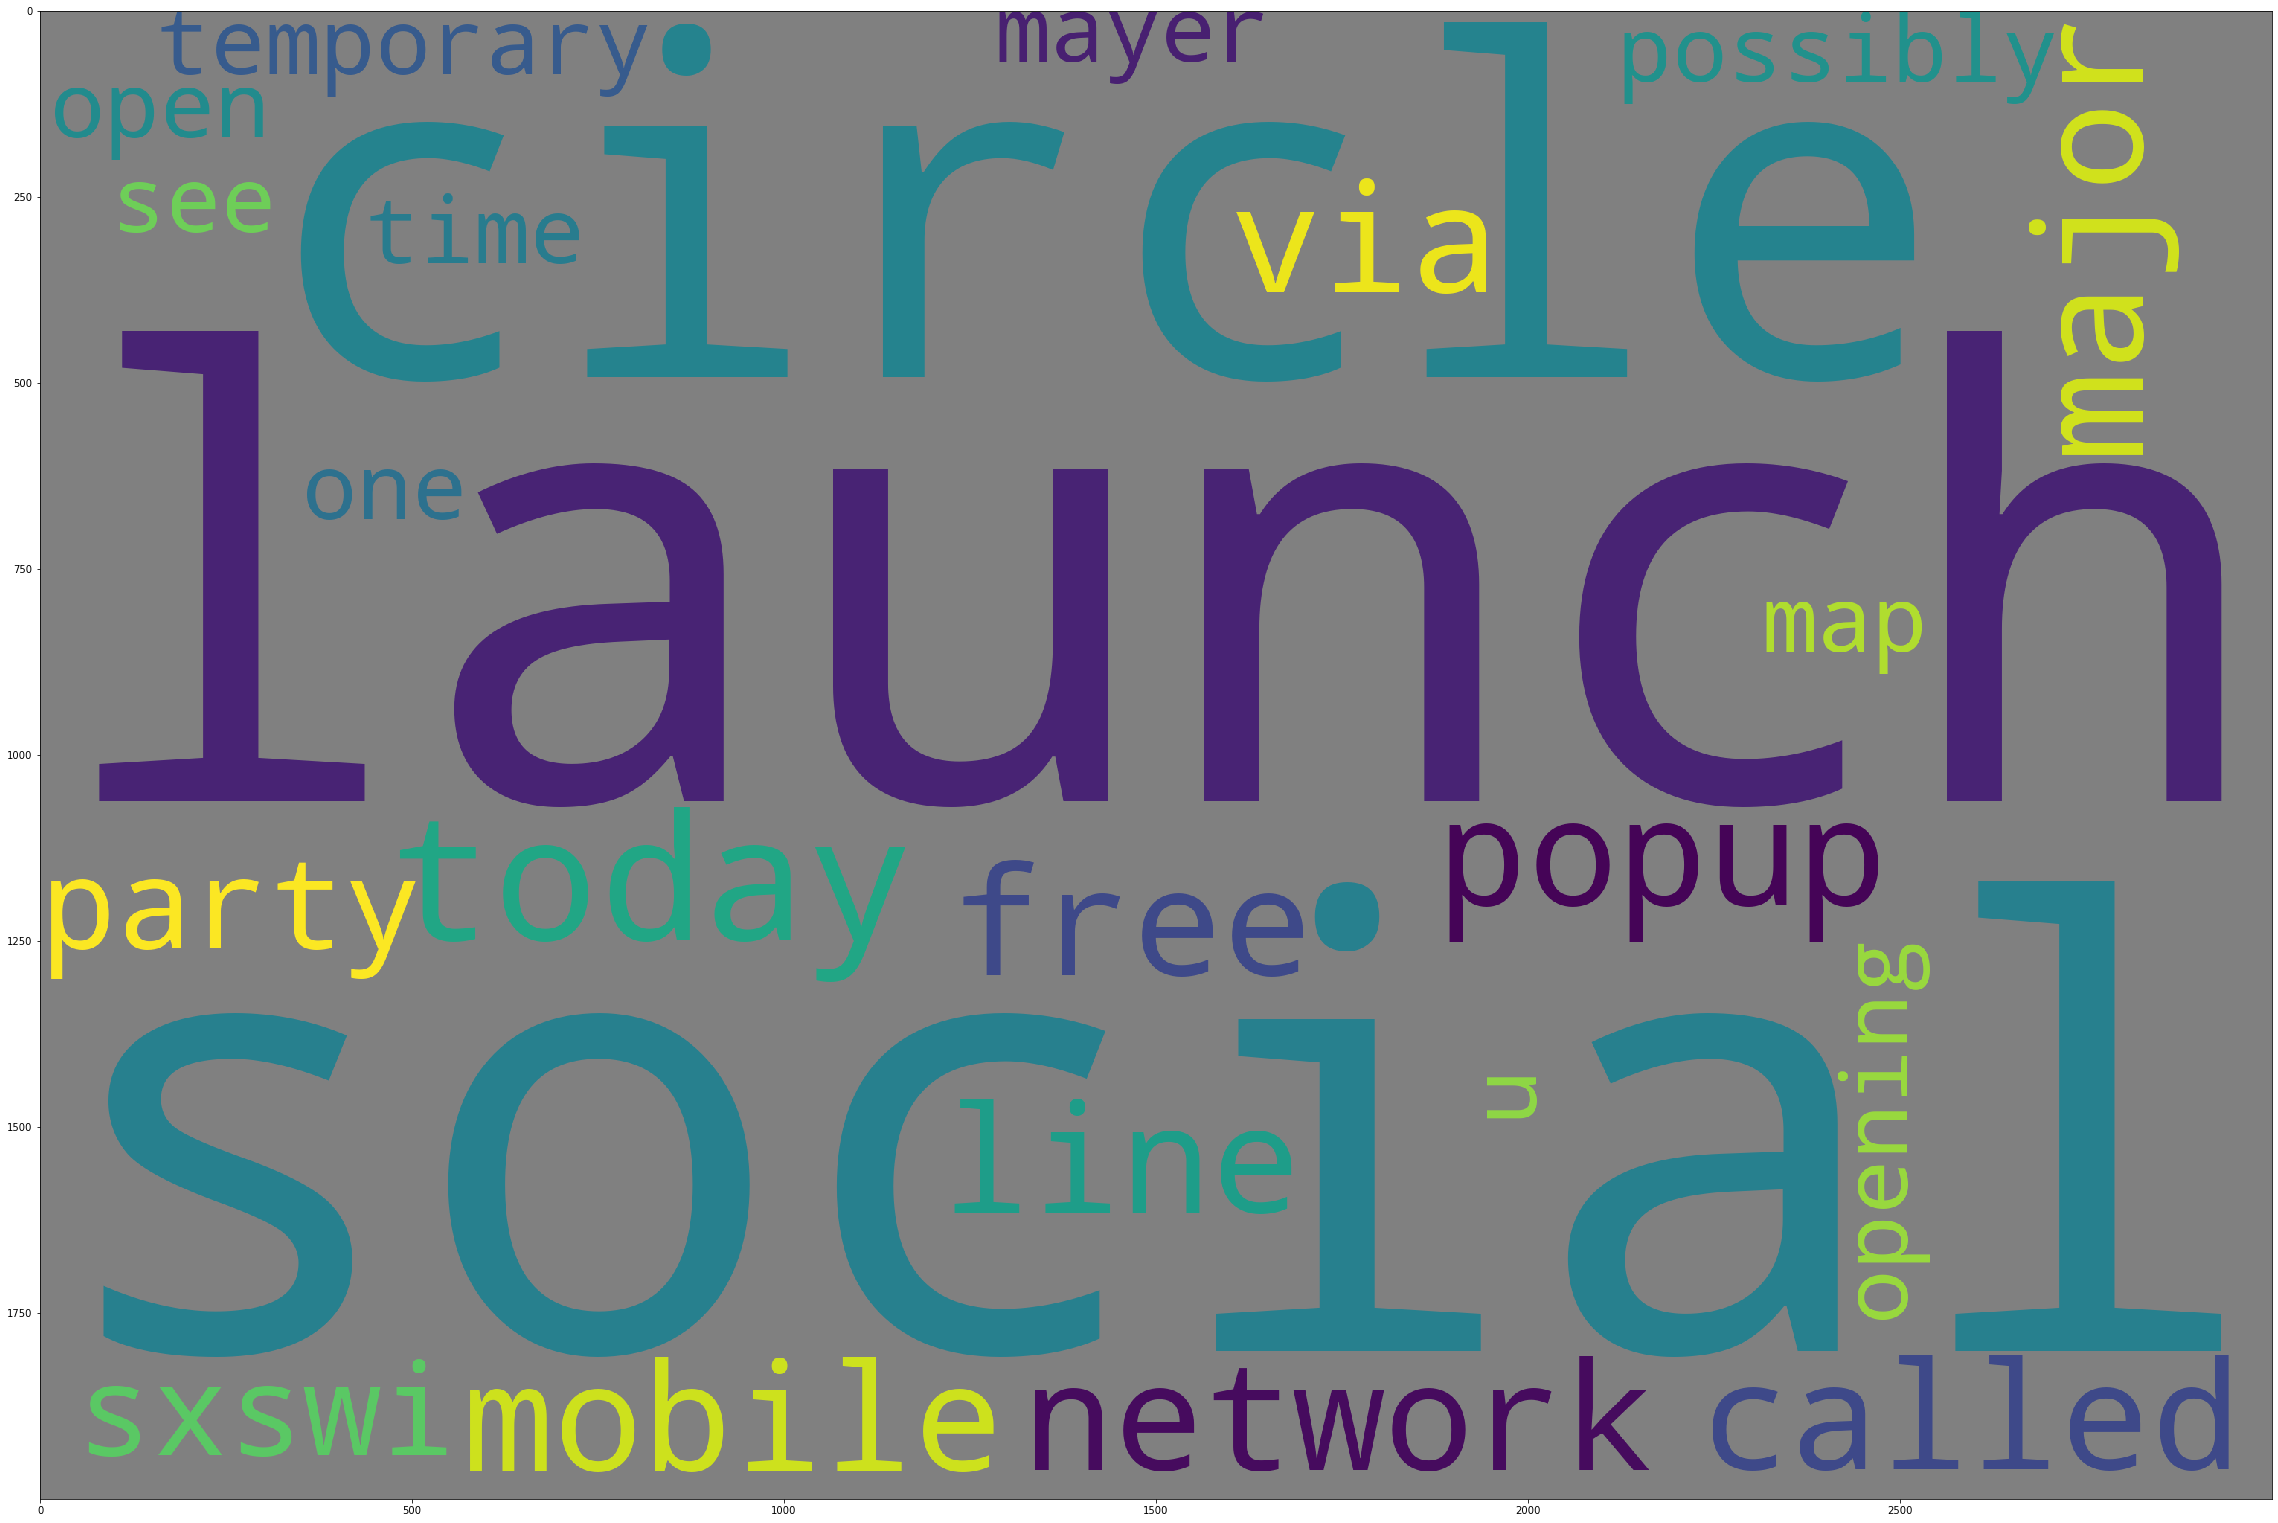

In [32]:
world_cloud(nn_tops)